In [33]:
import tabletext
import json
from datetime import datetime
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.relativedelta import *
from matplotlib.ticker import FuncFormatter
import numpy as np

In [34]:
# Set some constants for analysis

MIN_YEAR = 2007
MAX_YEAR = 2016
PIVOT_YEAR = 2011
CITY = 'DURHAM'
VALID_TYPES = ["1 - Restaurant", "2 - Food Stands", "3 - Mobile Food"]

In [35]:
# Roll up the number of openings in a given month.

openings = {
   y: {m: 0 for m in range(1, 13)} for y in range(MIN_YEAR, MAX_YEAR + 1)
}

# https://opendurham.nc.gov/explore/dataset/restaurants-data/
with open('data/restaurants-data.json', 'r') as f:
    for r in json.load(f):
        fields = r['fields']
        
        if fields['type_description'] not in VALID_TYPES:
            continue

        dt = datetime.strptime(fields['opening_date'], '%Y-%m-%d').date()

        if dt.year < MIN_YEAR or dt.year > MAX_YEAR:
            continue

        openings[dt.year][dt.month] += 1

after = []
before = []
cumulative_data = []
for year_key, year_value in openings.items():
    for month_key, count in year_value.items():
        item_dt = datetime(year=year_key, month=month_key, day=1)
        cumulative_data.append({'date': item_dt, 'count': count})

        if year_key > PIVOT_YEAR:
            after.append(count)
        else:
            before.append(count)

In [36]:
# Generate a table of summary stats.

before_stats = st.describe(before)
after_stats = st.describe(after)

before_ci = st.t.interval(0.95, len(before)-1, loc=np.mean(before), scale=st.sem(before))
after_ci = st.t.interval(0.95, len(after)-1, loc=np.mean(after), scale=st.sem(after))

before_mode = st.mode(before).mode
after_mode = st.mode(after).mode

table_data = [
    ["statistic", "Before", "After"],
    ["n", before_stats.nobs, after_stats.nobs],
    ["Minimum", before_stats.minmax[0], after_stats.minmax[0]],
    ["Maximum", before_stats.minmax[1], after_stats.minmax[1]],
    ["Mode", before_mode[0], after_mode[0]],
    ["Mean", round(before_stats.mean, 2), round(after_stats.mean, 2)],
    ["Variance", round(before_stats.variance, 2), round(after_stats.variance, 2)],
    ["Skewness", round(before_stats.skewness, 2), round(after_stats.skewness, 2)],
    ["Kurtosis", round(before_stats.kurtosis, 2), round(after_stats.kurtosis, 2)],
    ["95% CI (Low)", round(before_ci[0], 2), round(after_ci[0], 2)],
    ["95% CI (High)", round(before_ci[1], 2), round(after_ci[1], 2)]
]


print(tabletext.to_text(table_data))

┌───────────────┬────────┬───────┐
│ statistic     │ Before │ After │
├───────────────┼────────┼───────┤
│ n             │     60 │    60 │
├───────────────┼────────┼───────┤
│ Minimum       │      0 │     2 │
├───────────────┼────────┼───────┤
│ Maximum       │      9 │    22 │
├───────────────┼────────┼───────┤
│ Mode          │      3 │     5 │
├───────────────┼────────┼───────┤
│ Mean          │   3.88 │  8.35 │
├───────────────┼────────┼───────┤
│ Variance      │   4.88 │  18.2 │
├───────────────┼────────┼───────┤
│ Skewness      │    0.3 │  1.16 │
├───────────────┼────────┼───────┤
│ Kurtosis      │  -0.66 │  1.44 │
├───────────────┼────────┼───────┤
│ 95% CI (Low)  │   3.31 │  7.25 │
├───────────────┼────────┼───────┤
│ 95% CI (High) │   4.45 │  9.45 │
└───────────────┴────────┴───────┘


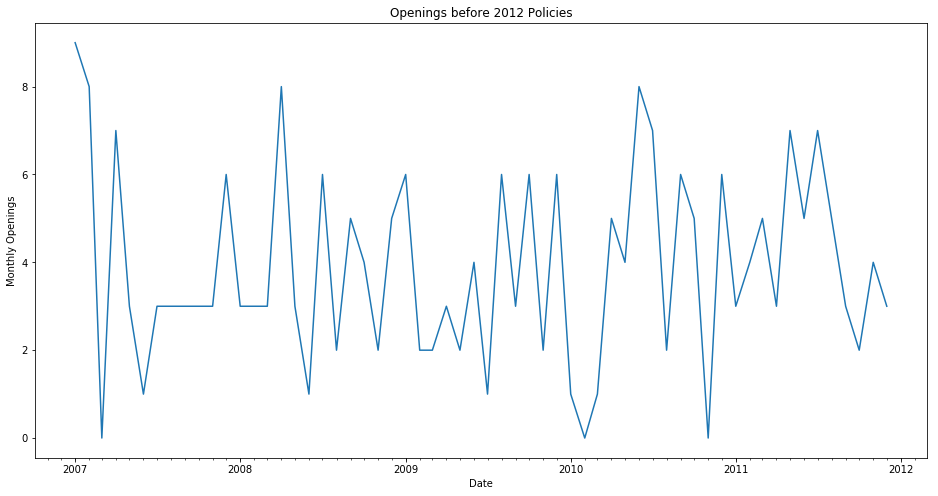

In [37]:
# Plot a time series of openings before 2012 policies.

plt.figure(figsize=(16, 8))
plt.title("Openings before 2012 Policies")
plt.xlabel('Date')
plt.ylabel('Monthly Openings')

epoch = datetime(2007, 1, 1)

years = mdates.YearLocator()
months = mdates.MonthLocator()
yearsFmt = mdates.DateFormatter('%Y')

plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_minor_locator(months)
plt.gca().xaxis.set_major_formatter(yearsFmt)

x = [epoch + relativedelta(months=+i) for i in range(len(before))]
plt.plot(x, before)

plt.savefig('figures/before_time_series.png')            

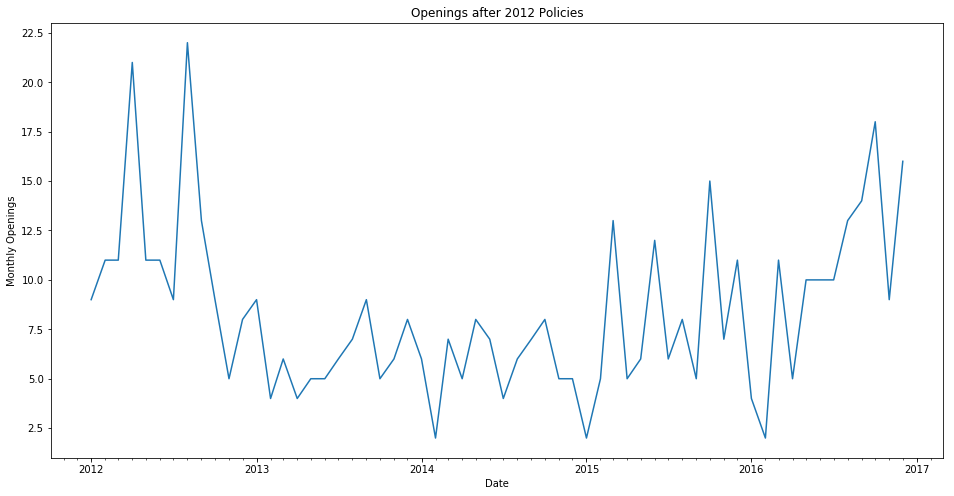

In [38]:
# Plot a time series of openings after 2012 policies.

plt.figure(figsize=(16, 8))
plt.title("Openings after 2012 Policies")
plt.xlabel('Date')
plt.ylabel('Monthly Openings')

epoch = datetime(2012, 1, 1)

years = mdates.YearLocator()
months = mdates.MonthLocator()
yearsFmt = mdates.DateFormatter('%Y')

plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_minor_locator(months)
plt.gca().xaxis.set_major_formatter(yearsFmt)

x = [epoch + relativedelta(months=+i) for i in range(len(after))]
plt.plot(x, after)

plt.savefig('figures/after_time_series.png')

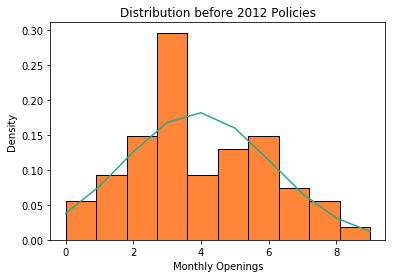

In [39]:
# Show a histogram of the 'before' distribution

b_dist = sorted(before)
fit = st.norm.pdf(b_dist, np.mean(before), np.std(before))
plt.plot(b_dist, fit,'-', color='#26AA8D')
plt.hist(b_dist, density=True, color='#FF8539', edgecolor = 'black')

plt.title("Distribution before 2012 Policies")
plt.xlabel('Monthly Openings')
plt.ylabel('Density')

plt.savefig('figures/before_dist.png')

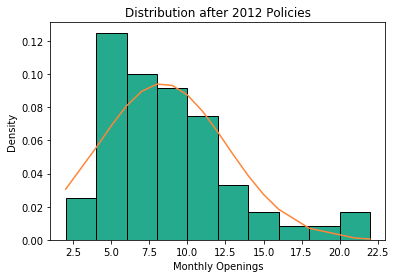

In [40]:
# Show a histogram of the 'after' distribution

a_dist = sorted(after)
fit = st.norm.pdf(a_dist, np.mean(after), np.std(after))
plt.plot(a_dist, fit,'-', color='#FF8539')
plt.hist(a_dist, density=True, color='#26AA8D', edgecolor = 'black')

plt.title("Distribution after 2012 Policies")
plt.xlabel('Monthly Openings')
plt.ylabel('Density')

plt.savefig('figures/after_dist.png')

In [41]:
# Show a t statistic and p value.

t_stat, p_val = st.ttest_rel(after, before)

t_stat_table = [
    ["T-Statistic", "P-Value"],
    [round(t_stat, 2), p_val]
]


print(tabletext.to_text(t_stat_table))

┌─────────────┬────────────────────────┐
│ T-Statistic │ P-Value                │
├─────────────┼────────────────────────┤
│        7.61 │ 2.5456860025032486e-10 │
└─────────────┴────────────────────────┘


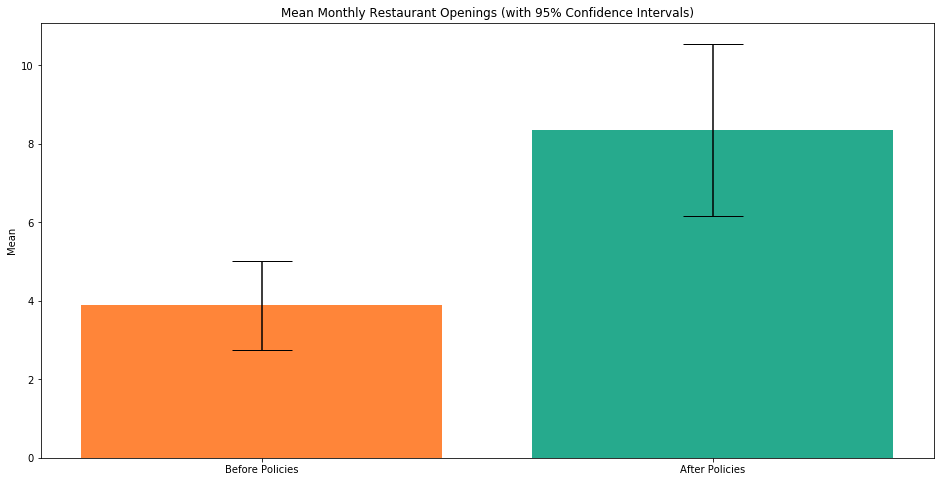

In [42]:
# Show bar chart with confidence intervals.

before_bar_height = round(before_stats.mean, 2)
after_bar_height = round(after_stats.mean, 2)

before_bar_ci = round(before_ci[1] - before_ci[0], 2)
after_bar_ci = round(after_ci[1] - after_ci[0], 2)

bars = [before_bar_height, after_bar_height]
cis = [before_bar_ci, after_bar_ci]

plt.figure(figsize=(16, 8))

x_loc = np.arange(len(bars))
 
plt.bar(x_loc, bars, color = ['#FF8539', '#26AA8D'], yerr=cis, capsize=30)
plt.title("Mean Monthly Restaurant Openings (with 95% Confidence Intervals)")
plt.xticks(x_loc, ['Before Policies', 'After Policies'])
plt.ylabel('Mean')
 
plt.savefig('figures/bar_ci.png')

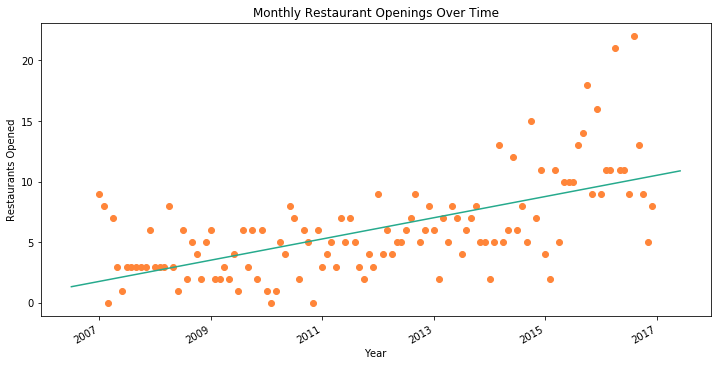

In [43]:
# Show a scatter plot of openings per month.

cumulative_data = sorted(cumulative_data, key=lambda x: x['date'])

x = mdates.date2num([val['date'] for val in cumulative_data])
y = [val['count'] for val in cumulative_data]

plt.figure(figsize=(12, 6))

plt.title("Monthly Restaurant Openings Over Time")
plt.xlabel("Year")
plt.ylabel("Restaurants Opened")

plt.scatter(x, y, color='#FF8539')

axes = plt.gca()

loc = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(loc)
plt.gca().xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
plt.gcf().autofmt_xdate()

m, b = np.polyfit(x, y, 1)
X_plot = np.linspace(axes.get_xlim()[0], axes.get_xlim()[1], len(cumulative_data))

plt.plot(X_plot, m*X_plot + b, '-', color='#26AA8D')
plt.savefig('figures/regression.png')